In [1]:
from lib import geoSearch
import json, logging
GS = geoSearch.GeoSearch("elasticsearch-geo",9200)
from shapely.geometry import mapping, shape
geoSearch.logger.setLevel(logging.INFO)

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.25.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix as cm
%matplotlib inline  

test_set = pd.read_csv('exactTestDataset.csv', index_col=0, encoding='utf-8')

In [4]:
test_set.head()

,ubicacion,alternativa,texto,matchType
0,mercedes#tacuarembo,mercedes#tacuarembo,hola imtransito semaforo esquina tacuarembo es...,cruces_vias
1,dr-emilio-frugoni#chana,dr-emilio-frugoni#chana,imtransito comomemuevouy mvdtransporte chana e...,cruces_vias
2,palacio-legislativo-edificio-anexo&palacio-leg...,palacio-legislativo-edificio-anexo&palacio-leg...,montevideo ahora choque esquina palacio legisl...,geonames
3,santa-cruz-de-la-sierra#vizcaya,santa-cruz-de-la-sierra#vizcaya,sharito17849631 mvddecide belvederegatos munic...,cruces_vias
4,arenal-grande#colonia,arenal-grande#colonia,hecho historico medicina mundial ciudad montev...,cruces_vias


In [35]:
score_limit = 0

In [36]:
test_set_run = GS.test_kit('exactTestDataset.csv', score_limit)

In [37]:
test_set_run.head()

,ubicacion,alternativa,texto,matchType,ubicacionEncontrada,scoreMejorMatch,tipoUbicacionEncontrada,time_ms
0,mercedes#tacuarembo,mercedes#tacuarembo,hola imtransito semaforo esquina tacuarembo es...,cruces_vias,mercedes#tacuarembo,319055.469818,cruces_vias,38.605
1,dr-emilio-frugoni#chana,dr-emilio-frugoni#chana,imtransito comomemuevouy mvdtransporte chana e...,cruces_vias,dr-emilio-frugoni#chana,50818.370978,cruces_vias,13.393
2,palacio-legislativo-edificio-anexo&palacio-leg...,palacio-legislativo-edificio-anexo&palacio-leg...,montevideo ahora choque esquina palacio legisl...,geonames,palacio-legislativo-edificio-anexo&palacio-leg...,1420.020446,geonames,18.011
3,santa-cruz-de-la-sierra#vizcaya,santa-cruz-de-la-sierra#vizcaya,sharito17849631 mvddecide belvederegatos munic...,cruces_vias,santa-cruz-de-la-sierra#vizcaya,521006.657877,cruces_vias,44.176
4,arenal-grande#colonia,arenal-grande#colonia,hecho historico medicina mundial ciudad montev...,cruces_vias,arenal-grande#colonia,231109.028718,cruces_vias,36.429


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fddfba9ca90>]], dtype=object)

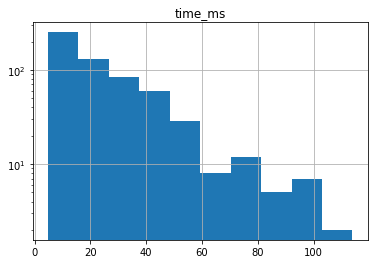

In [45]:
test_set_run.hist(column='time_ms', log=True)

In [39]:
test_set_run['truthLocation'] = np.where(test_set_run['ubicacion'] != '-', True, False)
test_set_run['truthTypeLocation'] = np.where(test_set_run['matchType'] != '-', True, False)

In [49]:
test_set_run['foundLocation'] = np.where(
    ((test_set_run['ubicacionEncontrada'] != '-') & (test_set_run['ubicacion'] == '-')) |
    ((test_set_run['ubicacionEncontrada'] == '-') &
    (test_set_run['ubicacion'] == test_set_run['ubicacionEncontrada']) |
    (test_set_run['alternativa'] == test_set_run['ubicacionEncontrada'])),True, False)
test_set_run['foundLocationType'] = np.where(
    (test_set_run['matchType'] == test_set_run['tipoUbicacionEncontrada']),True, False)

In [50]:
cm(test_set_run['truthLocation'], test_set_run['foundLocation'])

array([[  0, 465],
       [  0, 122]])

In [51]:
cm(test_set_run['truthTypeLocation'], test_set_run['foundLocationType'])

array([[288, 178],
       [  1, 120]])

In [43]:
test_set_run.to_csv('exactTestDatasetResult-Limit:{}.csv'.format(score_limit))